In [1]:
from extractors import GerchbergSaxton2d, SpotlightSolution1d, OptimalTransport1d, FlattenOptimalTransport2d
from utils.coordinates import CenteredGridCoordinates, RadialCoordinates
from utils.make_data import make_gauss, make_donut, make_disk, get_fly_test_image
from utils.fourier import FFT2, IFFT2

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_side_by_side(img1, img2, title1=None, title2=None):
    fig, ax = plt.subplots(1, 4, figsize=(13, 6), gridspec_kw={'width_ratios': [6, 0.5, 6, 0.5]})
    im1 = ax[0].imshow(img1)
    im2 = ax[2].imshow(img2)
    ax[0].axis('off')
    ax[2].axis('off')
    if title1 is not None:
        ax[0].set_title(title1)
    if title2 is not None:
        ax[2].set_title(title2)
    plt.colorbar(im1, ax[1])
    plt.colorbar(im2, ax[3])
    plt.show()

# Generate input / output example

In [3]:
n = 64  

# bin positions
coordGrid = CenteredGridCoordinates(n, n)
xs, ys = coordGrid.get_mesh()
r = np.sqrt(xs**2 + ys**2)

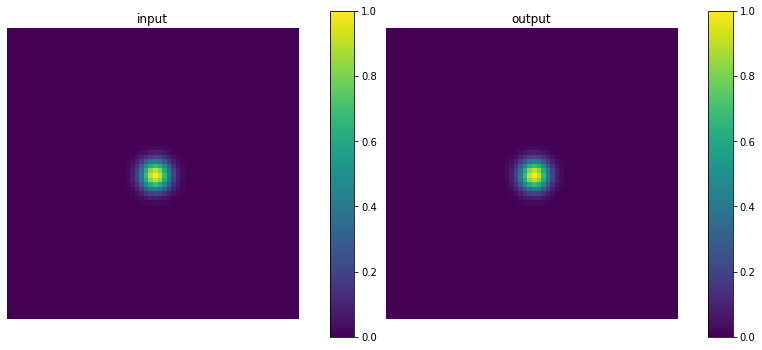

In [4]:
# create test data
a = make_gauss(r, 1/np.sqrt(2*np.pi))
b = make_gauss(r, 1/np.sqrt(2*np.pi))

assert np.isclose(
    np.abs(FFT2(np.sqrt(a)))**2/n**2, 
    make_gauss(r, 1/np.sqrt(2*np.pi))
    ).all()


plot_side_by_side(a, b, title1='input', title2='output')

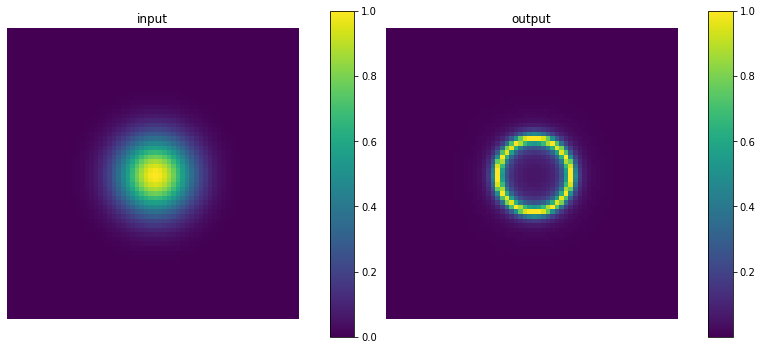

In [5]:
# create test data
a = make_gauss(r, 1)
b = make_donut(r, 1, 0.5)

plot_side_by_side(a, b, title1='input', title2='output')

# Extract Phase and Plot

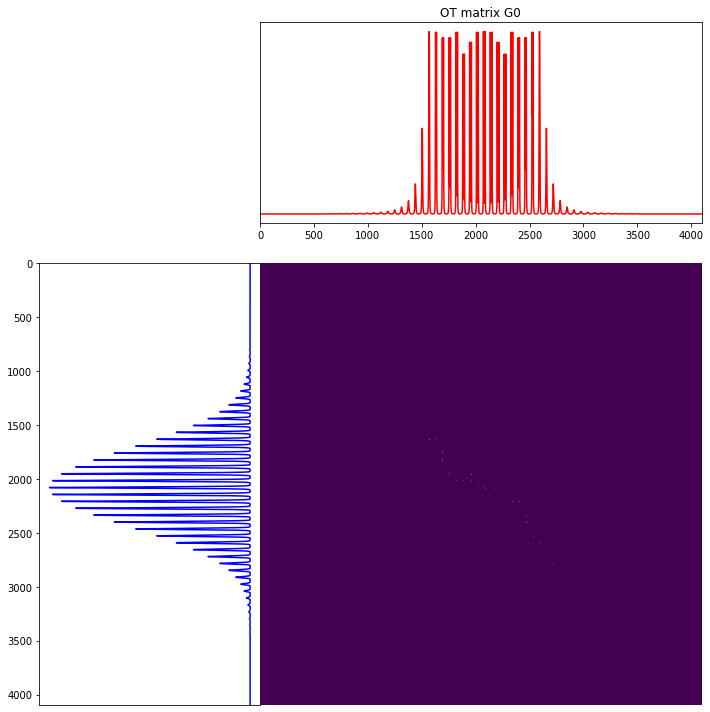

In [6]:
model = FlattenOptimalTransport2d(method='emd', reg=0.001, plot_plan=True) # method is either 'emd' or 'sinkhorn'
Fx, Fy, ot_phase, curl = model(a, b, xs, ys)

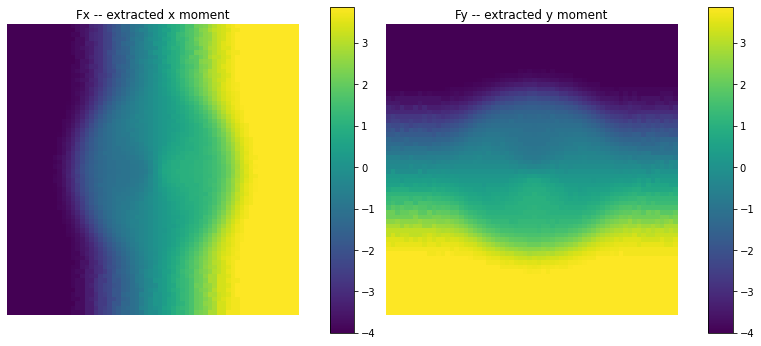

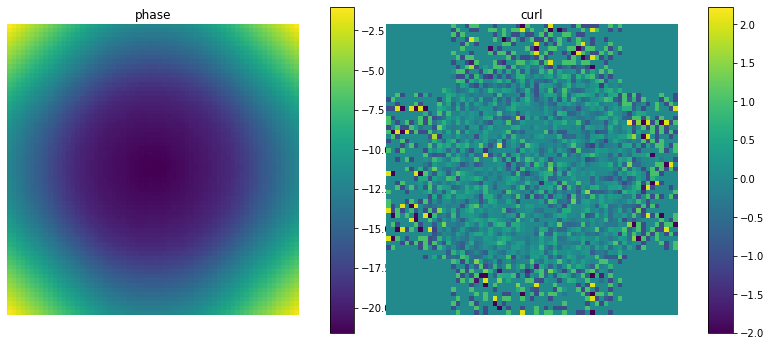

In [8]:
plot_side_by_side(Fx, Fy, title1='Fx -- extracted x moment', title2='Fy -- extracted y moment')
plot_side_by_side(ot_phase, curl, title1='phase', title2='curl')

# For radially symmetric problems we can check spotlight solutuion

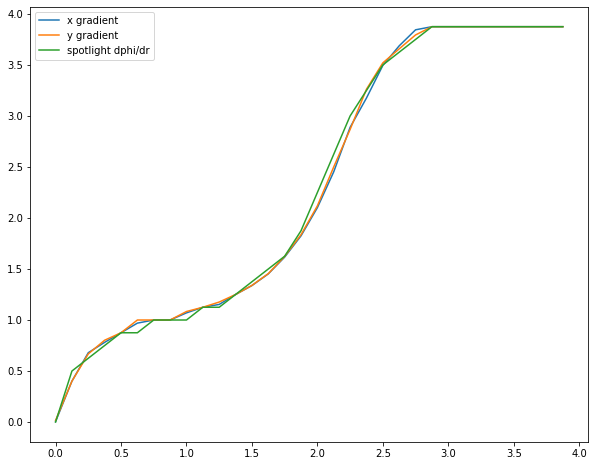

In [9]:
# extract 1d problem
r_line =r [n//2,n//2:] 
a_r = a[n//2,n//2:]*r_line
b_r = b[n//2,n//2:]*r_line
spotlight = SpotlightSolution1d()
dphidr = spotlight(a_r, b_r, r_line)

# plot and compare reuslts
plt.figure(figsize=(10, 8))
plt.plot(r_line, Fx[n//2,n//2:], label='x gradient')
plt.plot(r_line, Fy[n//2:,n//2], label='y gradient')
plt.plot(r_line, dphidr, label='spotlight dphi/dr')
plt.legend()
plt.show()

# Gerchberg Saxton

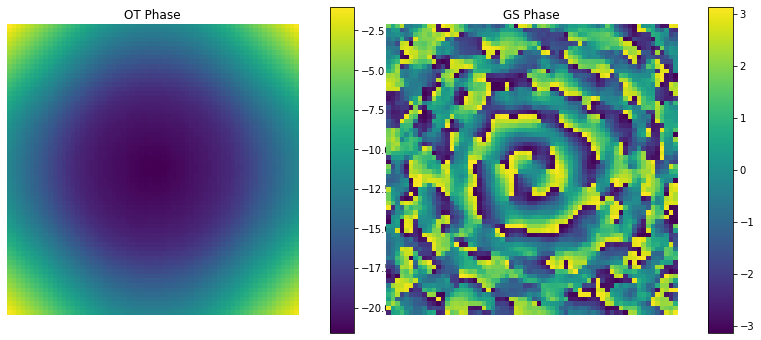

In [10]:
source_amplitude = np.sqrt(a/a.sum())
target_amplitude = np.sqrt(b/b.sum())

num_iter = 10000
gs_model = GerchbergSaxton2d(num_iter)
gs_phase = gs_model(source_amplitude, target_amplitude)
plot_side_by_side(ot_phase, gs_phase, title1='OT Phase', title2='GS Phase')

6.1646164616461645


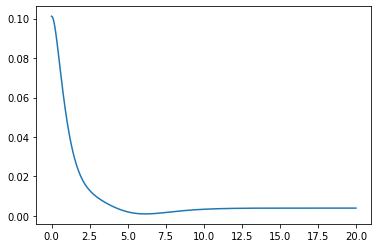

In [12]:
# Try to find a fudge factor
fudge_list = np.linspace(0, 20, 10000)
loss_list = []
for fudge in fudge_list:
    ot_reconstructed = FFT2(source_amplitude * np.exp(1j * fudge * ot_phase))
    ot_reconstructed = np.abs(ot_reconstructed)**2
    ot_reconstructed = ot_reconstructed/ot_reconstructed.sum()
    b = b/b.sum()
    l2 = ((ot_reconstructed - b) ** 2).sum()
    loss_list.append(l2)
plt.plot(fudge_list, loss_list)
print(fudge_list[np.argmin(loss_list)])

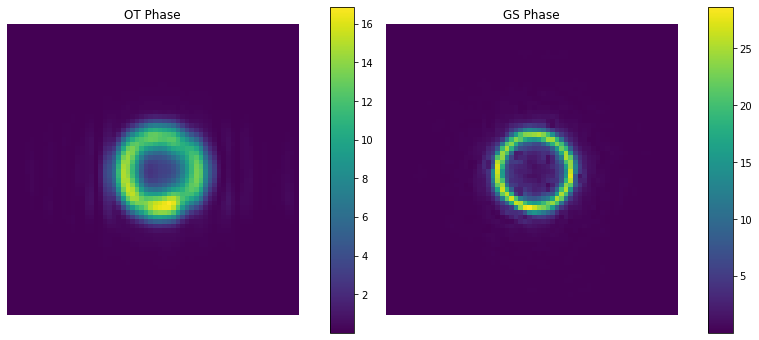

In [14]:
fudge = 2*np.pi # seems about right
ot_reconstructed = FFT2(source_amplitude * np.exp(1j * fudge * ot_phase))
gs_reconstructed = FFT2(source_amplitude * np.exp(1j * gs_phase))

ot_reconstructed = np.abs(ot_reconstructed)**2
gs_reconstructed = np.abs(gs_reconstructed)**2

plot_side_by_side(ot_reconstructed, gs_reconstructed, title1='OT Phase', title2='GS Phase')

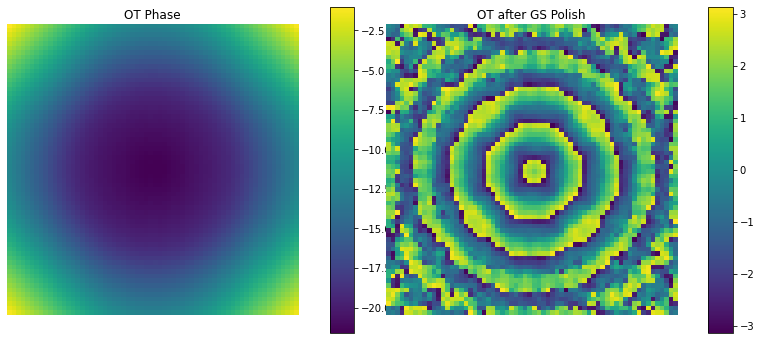

In [16]:
ot_phase_improved = gs_model(source_amplitude, target_amplitude, phase=fudge*ot_phase)
plot_side_by_side(ot_phase, ot_phase_improved, title1='OT Phase', title2=f'OT after GS Polish')

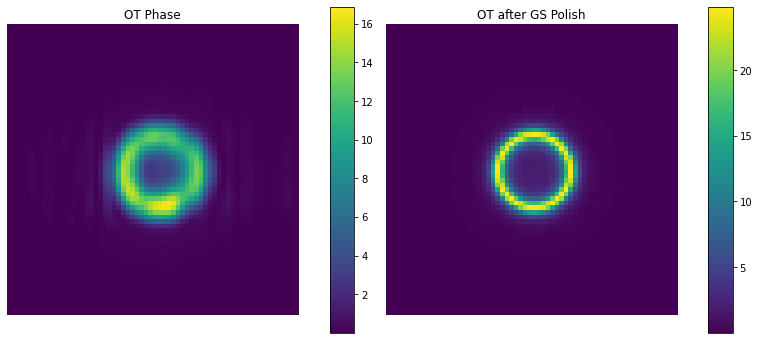

In [17]:
ot_reconstructed_improved = FFT2(source_amplitude * np.exp(1j * ot_phase_improved))
ot_reconstructed_improved = np.abs(ot_reconstructed_improved)**2
plot_side_by_side(ot_reconstructed, ot_reconstructed_improved, title1='OT Phase', title2=f'OT after GS Polish')